## This Notebook Uses a Simplified Binary Model Approach, we Scored an 0.79 with this method

In [1]:
import pandas as pd
import numpy as np

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from category_encoders import WOEEncoder
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import ExtraTreesClassifier

import xgboost
from xgboost import XGBClassifier

import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import gc; gc.enable()

## Import DataCleaner from preprocessor.py file
- refer to the preprocessor file to see how data was cleaned

In [2]:
from preprocessor import DataCleaner

### Read in Competition Files

In [3]:
#read in csv's and merge
values_df = pd.read_csv('train_set_values.csv')
labels_df = pd.read_csv('train_set_labels.csv')
test_df = pd.read_csv('test_set_values.csv')

df, df_test = DataCleaner(values_df, labels_df, test_df)
df.status_group.value_counts()

2    32259
0    22824
1     4317
Name: status_group, dtype: int64

## Combine targets 'functional' & 'functional needs repair'
This simplifies the project to a binary model, we can do this since only a small percentage of our data is 'functional needs repair', most data falls into 'functional' or 'non-functional'

In [4]:
#define target & make probelme binary
target = 'status_group'
df = df[(df[target] == 0) | (df[target] == 2)]
df[target] = df[target].replace(2, 1)

#JUST PREDICING FUNCTIONAL NEEDS REPAIR
#df[target] = df[target].replace(2, 0)

#used columns
used_cols = [c for c in df.columns.tolist() if c not in [target, 'id']]
X, y = df[used_cols], df[target]

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

df.status_group.value_counts()

1    32259
0    22824
Name: status_group, dtype: int64

## Best Model 
#### Overfit, but gave best results on the competition

TRAIN accuracy: 0.9387675709321023
TEST accuracy: 0.8767927382753404


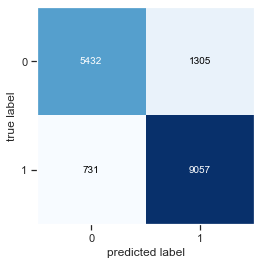

In [5]:
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 12, colsample_bytree = .4, learning_rate = 0.1)

pipe3 = make_pipeline(xgb)
pipe3.fit(X_train, y_train)

# make predictions on training set
y_guess = pipe3.predict(X_train)

# make predictions on hold-out set
y_score = pipe3.predict(X_test)

print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))

cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [6]:
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 14, colsample_bytree = .4)
score = np.mean(cross_val_score(xgb, X, y, cv = 5, n_jobs=-1, scoring = 'accuracy'))
print(score)

0.8747162382767424


In [7]:
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.1,
              eval_metric='merror', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=14, maximize=False,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nrounds='min.error.idx', nthread=None, num_class=3,
              objective='multi:softmax', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

## Predicting on the Test set, and getting in the right format

In [8]:
test_used_cols = [c for c in df_test.columns.tolist() if c not in ['id']]
X_test = df_test[test_used_cols]

test_predict = xgb.predict(X_test)
df_test['status_group'] = pd.Series(test_predict, index=df_test.id)
df_test['status_group'] = test_predict
df_test['status_group'] = df_test['status_group'].replace(0 ,'non functional') #0 is not functional
df_test['status_group'] = df_test['status_group'].replace(1, 'functional') #1 is functional
#df_test['status_group'] = df_test['status_group'].replace(2, 'functional') #1 is functional
df_submit = df_test[['id', 'status_group']]
df_submit.status_group.value_counts()

functional        9412
non functional    5438
Name: status_group, dtype: int64

In [24]:
df_submit.to_csv('try3.csv', index= False )

## Trying other models

In [ ]:
#light gbm
lgm = LGBMClassifier(booster = 'gbtree', nrounds = 'min.error.idx', maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 14, colsample_bytree = .4)

#fit
pipe2 = make_pipeline(lgm)
pipe2.fit(X_train, y_train)

# make predictions on training set
y_guess = pipe2.predict(X_train)

# make predictions on hold-out set
y_score = pipe2.predict(X_test)

#print accuacy
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))

#confusion matrix
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [ ]:
lgm = LGBMClassifier(random_state = 42, max_depth=6, n_estimators=200, boosting_type='gbdt')
pipe = make_pipeline(lgm)
score = np.mean(cross_val_score(pipe, X, y, cv = 5, n_jobs=-1, scoring = 'accuracy'))
print(score)

In [ ]:
bayes = GaussianNB()

pipe4 = make_pipeline(bayes)
pipe4.fit(X_train, y_train)

# make predictions on training set
y_guess = pipe4.predict(X_train)

# make predictions on hold-out set
y_score = pipe4.predict(X_test)

print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))

cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [ ]:
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

pipe = make_pipeline(lr)
pipe.fit(X_train, y_train)

#pipe.fit(X_train, y_train)

# make predictions on training set
y_guess = pipe.predict(X_train)

# make predictions on hold-out set
y_score = pipe.predict(X_test)

#ranked_predictions = predictions.rank(pct=True, method="first")
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))

cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [ ]:
ef = ExtraTreesClassifier(max_depth=5, criterion= 'gini', min_samples_leaf=3, min_samples_split=18, random_state=42, n_estimators = 57, class_weight='balanced', n_jobs = -1)

pipe8 = make_pipeline(ef)
pipe8.fit(X_train, y_train)

# make predictions on training set
y_guess = pipe8.predict(X_train)

# make predictions on hold-out set
y_score = pipe8.predict(X_test)

print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))

cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [ ]:
# bag = Bagginvalue_countssifier(pipe5, n_estimators=3)
sclf = StackingCVClassifier(classifiers=[pipe2, pipe4, pipe8],
                            use_probas=True, 
                            meta_classifier=pipe3,
                            random_state=42)

sclf.fit(X_train, y_train)

# make predictions on training set
y_guess = sclf.predict(X_train)

# make predictions on hold-out set
y_score = sclf.predict(X_test)

print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))

cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

## Parameter Tune

In [ ]:
# def auc_model(params):
#     clf = XGBClassifier(**params)
#     return cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5).mean()


# param_dict = {
#     'max_depth': range(3, 14), #good
#     'n_estimators': range(40, 200), #good
#     'booster': ["gbtree", "dart"],
#     #'min_samples_split': range(1, 20),
#     #'min_samples_leaf': range(1, 20)
# }

# param_space = {
#     'max_depth': hp.choice('max_depth', param_dict['max_depth']),
#     'n_estimators': hp.choice('n_estimators', param_dict['n_estimators']),
#     'booster': hp.choice('booster', param_dict['booster']),
#     #'min_samples_split': hp.choice('min_samples_split', param_dict['min_samples_split']),
#     #'min_samples_leaf': hp.choice('min_samples_leaf', param_dict['min_samples_leaf'])
# }

# best = 0
# def f(params):
#     global best
#     auc = auc_model(params)
#     if auc > best:
#         best = auc
#     print ('new best:', best, params)
#     return {'loss': -auc, 'status': STATUS_OK}

# trials = Trials()
# best = fmin(f, param_space, algo=tpe.suggest, max_evals=50, trials=trials)

## One hot encode each categorical feature, one at a time

In [ ]:
#RUN THROUGH AND ONE HOT EVERYTHING

# for c in ohe:
#     onehot = DummyEncoder([c])
#     print(c + '  onehot')
#     z = [d for d in ohe if d != c]
#     print(z)
#     p = [e for e in te if e not in z]
#     print(p)
#     encoder = TargetEncoder(cols = z)
#     encoder1 = TargetEncoder(cols = p)
#     print(list(X_train.columns))
# #     X_train, X_test, y_train, y_test = train_test_split(X, y, 
# #                                                     test_size=0.3, 
# #                                                     random_state=42)
#     lgm = LGBMClassifier(random_state = 42, max_depth=6, n_estimators=150, boosting_type='gbdt')

#     pipe2 = make_pipeline(encoder, encoder1, onehot, lgm)
#     pipe2.fit(X_train, y_train)

#     # make predictions on training set
#     y_guess = pipe2.predict(X_train)

#     # make predictions on hold-out set
#     y_score = pipe2.predict(X_test)

#     print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
#     print("TEST accuracy:",accuracy_score(y_test, y_score))

#     cm = confusion_matrix(y_test, y_score)
#     plot_confusion_matrix(cm)
#     plt.show()
